In [1]:
# Changing the directory into notebooks paths
%cd /content/drive/MyDrive/My Projects/celeb-LBP-face-recognition   

/content/drive/MyDrive/My Projects/celeb-LBP-face-recognition


In [2]:
!pip install import-ipynb

In [3]:
import import_ipynb
from face import load_face_dataset

from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import math
import imutils
import time
import cv2
import os

importing Jupyter notebook from face.ipynb


**Note** : If you save the model, model file will take about `~1.2GB` of your memory. So be careful if you want to save it.

In [4]:
def cross_validation(input_data , cv = 5 , test_size = 0.20 , output = True , save_model=False):

  # initialize the f1-scores list
  f1_scores = []
  # grab some random numbers between 0 and 100
  random_states = np.random.randint(low = 0, high = 100 , size = cv , dtype = int)

  # extract faces and label from dataset
  (faces , labels) = load_face_dataset(input_data , minSamples=15)

  # encode the labels
  le = LabelEncoder()
  labels = le.fit_transform(labels)

  # do the training process based on the number of 
  # random_states
  for random_state in random_states:
    # split the data into training and test set
    X_train , X_test , y_train , y_test = train_test_split(faces , labels , test_size = test_size,
                                                          stratify = labels , random_state = random_state)
    
    # define and train the LBP model
    recognizer = cv2.face.LBPHFaceRecognizer_create(
        radius = 2 , neighbors = 16 , grid_x = 9 , grid_y  = 9)

    recognizer.train(X_train , y_train)

    # initialize our predictions and confidence lists
    predictions = []
    confidence = []

    # loop over the test data
    for i in range(0 , len(X_test)):
      # classify the face and update the predictions
      # and confidence scores
      (prediction , conf) = recognizer.predict(X_test[i])
      predictions.append(prediction)
      confidence.append(confidence)

    # collect and append the calculated f1-score based on this
    # random state
    f1_scores.append(f1_score(y_test,predictions,average="macro"))

  # convert the f1-scores list into Numpy array
  f1_scores = np.array(f1_scores , dtype="float32")

  if output:
    # generate a sample of testing data
    idxs = np.random.choice(range(0 , len(X_test)) , size = 10 , replace = False)

    for i in idxs:
      # grab the actual and predicted name
      predName = le.inverse_transform([predictions[i]])[0]
      actualName = le.classes_[y_test[i]]

      # grab the face image, convert back it from 1 channel
      # into 3 channels and then resize it
      face = np.dstack([X_test[i]] * 3)
      face = imutils.resize(face , width = 250)

      # draw the actual and predicted name on the image
      cv2.putText(face , "actual : {}".format(actualName) , (5 , 25),
                  cv2.FONT_HERSHEY_SIMPLEX , 0.8 , (0 , 0 , 255) , 2)
      cv2.putText(face , "prediction : {}".format(predName) , (5 , 60),
                  cv2.FONT_HERSHEY_SIMPLEX , 0.8 , (0 , 255 , 0) , 2)
      
      # display the result image and the save it into
      # the desired directory 
      plt.imshow(face , cmap="gray")
      plt.savefig("output/lbp-faces/face-{}.png".format(i))
    # save the model 
  
  if save_model:
    # save the model 
    recognizer.save("face-recognizer-model.yml")

  return f1_scores

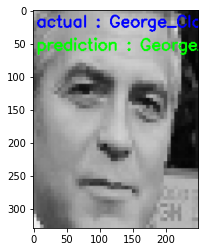

In [5]:
f1_scores = cross_validation("celeb-data" , cv=5 , save_model=True)

In [6]:
# grab the mean of f1-scores
mu = np.mean(f1_scores)
# grab the standard deviation of f1-scores
sigma = np.std(f1_scores)

print("The mean of f1-scores is : " , mu)
print("The standard deviation of f1-scores is : " , sigma)

The mean of f1-scores is :  0.9423809
The standard deviation of f1-scores is :  0.036013212


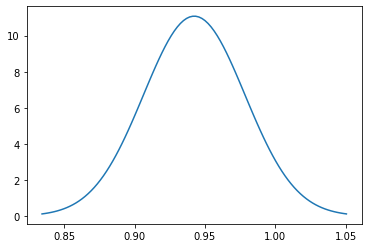

In [7]:
# calculate and divide the normal dist. range into 100 points
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
# plot the normal dist. based on the probability distribution function 
# values 
plt.plot(x, stats.norm.pdf(x, mu, sigma))
# save the plot in the desired directory
plt.savefig("output/model-performance/f-scores-dist.png")
plt.show()